In [1]:
from datasets import load_from_disk
from transformers import AutoTokenizer
import os
sns.set_style("whitegrid", {'axes.grid' : False})
import transformers

NameError: name 'sns' is not defined

In [51]:
# look into /n/fs/nlp-mengzhou/space3/meta/data/copa.bin/threshold0.15.list and turn it into the current format
def transform(data):
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    
    def decode(examples):
        lens = len(examples["src_tokens"])
        prompts = []
        char_starts = []
        char_ends = []
        labels = []
        for i in range(lens):
            src_tokens = examples["src_tokens"][i]
            prompt = tokenizer.decode(src_tokens[1:-1])

            span_start_ends = examples["span_start_ends"][i]
            span_tokens = src_tokens[span_start_ends[0][0]: span_start_ends[1][0]]
            span = tokenizer.decode(span_tokens)
            
            label = examples["targets"][i][0]
            
            if span in prompt:
                char_start = prompt.index(span)

                char_end = char_start + len(span)
                char_starts.append([char_start])
                char_ends.append([char_end])
                prompts.append(prompt)
                labels.append(label)
                
            
        examples["prompt"] = prompts
        examples["char_start"] = char_starts
        examples["char_end"] = char_ends
        examples["label"] = labels
        return examples
            
    data = data.map(decode, batched=True, remove_columns=list(data.features.keys()), num_proc=20)
    return data

def run():
    valid_file = "/n/fs/nlp-mengzhou/space3/meta/data/copa.bin/threshold0.15.list/valid.pt"
    valid_data = load_from_disk(valid_file)
    train_file = "/n/fs/nlp-mengzhou/space3/meta/data/copa.bin/threshold0.15.list/train.pt"
    train_data = load_from_disk(train_file)
    
    transformed_valid_data = transform(valid_data)
    transformed_train_data = transform(train_data)
    
    save_dir = "/n/fs/nlp-mengzhou/space3/data/created/copa-retrieval0.15"
    os.makedirs(save_dir, exist_ok=True)
    save_train_file = os.path.join(save_dir, "train.pt")
    save_valid_file = os.path.join(save_dir, "valid.pt")
    transformed_train_data.save_to_disk(save_train_file)
    transformed_valid_data.save_to_disk(save_valid_file)
    return transformed_train_data, transformed_valid_data

train_data, valid_data = run()

In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator
from transformers import AutoTokenizer 
dataset_name = "sst2"
dataset = load_dataset("glue", dataset_name)["validation"]

Reusing dataset glue (/home/ubuntu/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [131]:
import torch
main_dir="/home/ubuntu/space3/out/hf/analysis_v1"
electra_reps = torch.load(f"{main_dir}/google/electra-base-discriminator/{dataset_name}/reps.pt")
bert_mask_reps = torch.load(f"{main_dir}/bert-base-uncased/{dataset_name}/reps.pt")

# legacy_dir="/home/ubuntu/space3/analysis/analysis-v1/legacy"
# electra_legacy_reps = torch.load(f"{legacy_dir}/sst2-electra.reps")
# bert_mask_legacy_reps = torch.load(f"{legacy_dir}/sst2-bert-mask.reps")

In [132]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
def get_x(input=1):
    return [input] * 767 + [((- electra_bias - input * sum(electra_weight[0, :-1])) / electra_weight[0, -1]).item()]
def get_x2(input=2):
    return [input] * 300 + [((- electra_bias - input * sum(electra_weight[0, :-468])) / electra_weight[0, 300:]).item()] * 468
electra_reps = normalize(electra_reps)
bert_mask_reps = normalize(bert_mask_reps)
p1 = normalize([get_x(1)])
p2 = normalize([get_x(4)])
ps = np.array([p1[0], p2[0]])

In [133]:
pca = PCA(n_components=2)
pca_bert = pca.fit_transform(bert_mask_reps)

In [134]:
pca = PCA(n_components=2).fit(electra_reps)
pca_electra = pca.transform(electra_reps)
ps = pca.transform(ps)

In [118]:
tse = TSNE(n_components=2, learning_rate='auto', init='random')
tse_bert = tse.fit_transform(bert_mask_reps)

In [119]:
tse = TSNE(n_components=2, learning_rate='auto', init='random')
tse_electra = tse.fit_transform(electra_reps)

In [120]:
electra_labels = []
labels = dataset.features["label"].names
for i in dataset["label"]:
    if i == 0:
        electra_labels.append("electra real positive")
        electra_labels.append("electra fake negative")
    else:
        electra_labels.append("electra fake positive")
        electra_labels.append("electra real negative")
color_map = {"electra real positive": "y", "electra real negative": "plum", "electra fake positive": "g", "electra fake negative": "b" }
electra_colors = [color_map[label] for label in electra_labels]

bert_labels = ["bert real positive" if i == 0 else "bert real negative" for i in dataset["label"]]
bert_color_map = {"bert real positive": "steelblue", "bert real negative": "orange"}
bert_colors = [bert_color_map[label] for label in bert_labels]

In [121]:
electra = transformers.ElectraForPreTraining.from_pretrained("google/electra-base-discriminator")

In [122]:
electra_weight = electra.discriminator_predictions.dense_prediction.weight
electra_bias = electra.discriminator_predictions.dense_prediction.bias

In [136]:
ps

array([[0.19760444, 0.57395462],
       [0.19783528, 0.57326851]])

In [139]:

ps[1, 0] = 1
ps[1, 1] = 1.16128-2.97223

Text(0.5, 1.0, 'sst2')

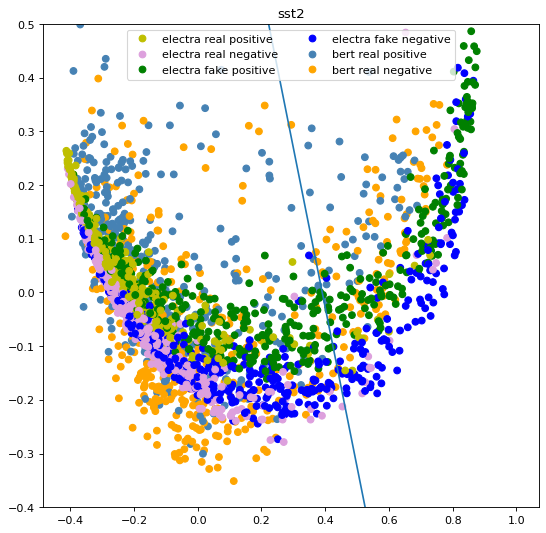

In [140]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(pca_bert[:, 0], pca_bert[:, 1], c=bert_colors, label=bert_labels)
plt.scatter(pca_electra[:, 0], pca_electra[:, 1], label=electra_labels, c=electra_colors)
plt.plot(ps[:, 0], ps[:, 1])

import matplotlib.lines as mlines
patches = []
for label in color_map:
    patch = mlines.Line2D([], [], color=color_map[label], marker='o', linestyle='None', markersize=6, label=label)
    patches.append(patch)
for label in bert_color_map:
    patch = mlines.Line2D([], [], color=bert_color_map[label], marker='o', linestyle='None', markersize=6, label=label)
    patches.append(patch)
plt.ylim(-0.4, 0.5)
plt.legend(handles=patches, loc=0, ncol=2)
plt.title("sst2")

In [77]:
ps

array([[0.1586622, 0.6805651]])

In [49]:
len(sst2_dataset)

3

In [53]:
sst2_dataset["validation"].features["label"].names

['entailment', 'neutral', 'contradiction']

In [1]:
import os
from datasets import load_from_disk

for ob in ["mlm", "dis"]:
    for task in ["sst2_aug", "sst2_v2_aug", "nli_aug", "nli_v2_aug", "boolq_aug"]:
        file = f"/n/fs/nlp-mengzhou/space3/meta/data/created/heuristic/keywords-v2/prompt_dataset/{ob}/{task}/train.pt"
        dataset = load_from_disk(file)
        output_file = os.path.join(os.path.dirname(file), "train.txt")
        with open(output_file, "w") as f:
            for ex in dataset:
                f.write(f"{ex['prompt']}\n")